In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本,形状为50的张量，且元素的范围为0-5

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 4, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

40

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

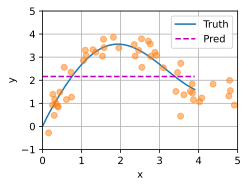

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [5]:
print(f"x train shape: {x_train.shape}")
print(x_train)
print(f"x test shape: {x_test.shape}")
print(x_test)

x train shape: torch.Size([50])
tensor([0.1560, 0.2572, 0.2638, 0.2992, 0.3121, 0.3438, 0.3868, 0.4009, 0.4440,
        0.5541, 0.6132, 0.7282, 0.7442, 1.0475, 1.0950, 1.1182, 1.2922, 1.3642,
        1.5359, 1.5612, 1.5744, 1.8159, 1.9550, 2.3520, 2.3732, 2.4635, 2.5364,
        2.5461, 2.7113, 2.7604, 2.7708, 2.8781, 2.9190, 3.0965, 3.4181, 3.4597,
        3.5379, 3.5429, 3.6229, 3.7894, 3.8347, 3.8417, 3.8694, 4.0225, 4.0811,
        4.3699, 4.7756, 4.7942, 4.8130, 4.9151])
x test shape: torch.Size([40])
tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000])


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [3.7000, 3.7000, 3.7000,  ..., 3.7000, 3.7000, 3.7000],
        [3.8000, 3.8000, 3.8000,  ..., 3.8000, 3.8000, 3.8000],
        [3.9000, 3.9000, 3.9000,  ..., 3.9000, 3.9000, 3.9000]])
X repeat shape: torch.Size([40, 50])
tensor([[-0.1560, -0.2572, -0.2638,  ..., -4.7942, -4.8130, -4.9151],
        [-0.0560, -0.1572, -0.1638,  ..., -4.6942, -4.7130, -4.8151],
        [ 0.0440, -0.0572, -0.0638,  ..., -4.5942, -4.6130, -4.7151],
        ...,
        [ 3.5440,  3.4428,  3.4362,  ..., -1.0942, -1.1130, -1.2151],
        [ 3.6440,  3.5428,  3.5362,  ..., -0.9942, -1.0130, -1.1151],
        [ 3.7440,  3.6428,  3.6362,  ..., -0.8942, -0.9130, -1.0151]])
torch.Size([40, 50])
torch.Size([40, 50])
torch.Size([40])


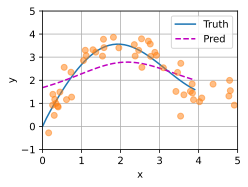

In [6]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
print(X_repeat)
print(f"X repeat shape: {X_repeat.shape}")
print(X_repeat - x_train)
print((X_repeat - x_train).shape)
attention_weights = nn.functional.softmax(- (X_repeat - x_train) ** 2 / 2, dim=1)
print(attention_weights.shape)
y_hat = torch.matmul(attention_weights, y_train)
print(y_hat.shape)
plot_kernel_reg(y_hat)

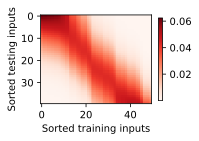

In [7]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [8]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [9]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

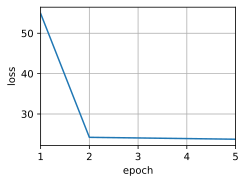

In [10]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

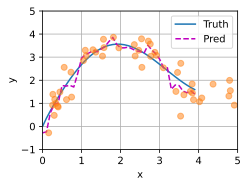

In [11]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

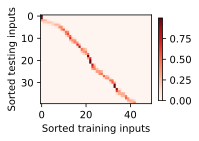

In [12]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')